In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

torch.manual_seed(42)

In [2]:
def optimize_method(primary_loss_func, constraint_func, theta_init, method='penalty', 
                    lambda_init=0.0, lambda_penalty=10.0, damping=1.0, lr=0.1,
                    iterations=50, theta_range = [-9.5, 10.0]):
    # Initialize theta and lambda (Lagrange multiplier)
    theta = torch.tensor(theta_init, requires_grad=True)
    lambda_val = torch.tensor([lambda_init], requires_grad=False)
    
    losses, constraints, lmbdas, thetas = [], [], [], []
    
    for _ in tqdm(range(iterations)):
        if theta.grad is not None:
            theta.grad.zero_()
        
        if method == 'penalty':
            constraint_penalty = lambda_penalty * constraint_func(theta) ** 2
            total_loss = primary_loss_func(theta) + constraint_penalty
            
        elif method in ['bdmm', 'mdmm']:
            infs = constraint_func(theta)
            l_term = lambda_val * infs
            damp_term = 0.0
            
            if method == 'mdmm':
                damp_term = 0.5 * damping * infs ** 2
                
            total_loss = primary_loss_func(theta) + l_term + damp_term
            
        else:
            raise ValueError(f"Unknown method: {method}")

        total_loss.backward(retain_graph=True) 
        
        with torch.no_grad():
            theta -= lr * theta.grad
            # theta.data = torch.clamp(theta.data, min=theta_range[0], max=theta_range[1])

        if method in ['bdmm', 'mdmm']:
            lambda_val +=  infs.detach() *lr
            # lambda_val = torch.clamp(lambda_val, min=0)  

        losses.append(primary_loss_func(theta).item())
        constraints.append(constraint_func(theta).item())
        lmbdas.append(lambda_val.clone().detach())  
        thetas.append(theta.clone().detach())       

    return losses, constraints, lmbdas, thetas

In [3]:
def primary_loss_convex(theta):
    return torch.sum(torch.log(1 + torch.exp(theta)))**1.5

def constraint_function_convex(theta):
    return torch.sum(torch.log(1 + torch.exp(-theta)))

In [4]:
def remove_consecutive_duplicates(lst):
    """Helper function to remove consecutive duplicates from a list."""
    return [v for i, v in enumerate(lst) if i == 0 or lst[i] != lst[i-1]]

def run_experient(lr = 0.001,
                    iterations =100,
                    lambda_init = 0.0,
                    lambda_penalty = 10.0,
                    damping = 1.0,
                    methods = ['penalty', 'bdmm', 'mdmm'],
                    case = {
                            'name': 'Convex',
                            'primary_loss_func': primary_loss_convex,
                            'constraint_func': constraint_function_convex,
                            'theta_range': [-4, 4],
                            'theta_init': -3.0,
                            }
                    ):
    colors = {'penalty': 'red', 'bdmm': 'green', 'mdmm': 'blue'}
    markers = {'penalty': 's', 'bdmm': 'o', 'mdmm': '^'}
    z_order = {'penalty': 4, 'bdmm': 2, 'mdmm': 3}
    
   
    print(f"Running {case['name']} Case...") 
    for method in methods:
        losses, constraints, lmbdas, thetas = optimize_method(
                                                primary_loss_func=case['primary_loss_func'],
                                                constraint_func=case['constraint_func'],
                                                theta_init=case['theta_init'],
                                                method=method,
                                                lambda_init=lambda_init,
                                                lambda_penalty=lambda_penalty,
                                                damping=damping,
                                                lr=lr,
                                                iterations=iterations
                                            )
                                            
        plt.scatter(losses, constraints, c=colors[method], marker=markers[method], alpha=0.05, zorder=0)
        plt.plot(losses, constraints, label=method.upper(), c=colors[method], marker=None, alpha=0.7, zorder=0)

        filtered_losses = remove_consecutive_duplicates(losses)
        filtered_constraints = remove_consecutive_duplicates(constraints)
            
        if len(filtered_losses) >= 2 and len(filtered_constraints) >= 2:
            plt.annotate('',
                         xy=(filtered_losses[-1], filtered_constraints[-1]),
                         xytext=(filtered_losses[-2], filtered_constraints[-2]),
                         arrowprops=dict(facecolor=colors[method], shrink=0.05,
                                         headwidth=10, headlength=20, width=2),
                         zorder=z_order[method])
    
    plt.xlabel('Primary Loss', fontsize=12)
    plt.ylabel('Constraint Loss', fontsize=12)
    
    plt.title(f"{case['name']} Pareto Front\nLearning Rate: {lr}, Iterations: {iterations}", fontsize=14, pad=5)
    plt.legend(loc='best', fontsize=10)
    
    plt.grid(True, linestyle='--') 
    plt.tight_layout()

    return plt, losses, constraints, lmbdas, thetas

In [5]:
def is_dominated(point, points):
    """
    Helper function to check if a point is dominated by any of the other points.
    A point is dominated if another point is strictly better in both objectives.
    """
    return np.any((points[:, 0] <= point[0]) & (points[:, 1] <= point[1]) & np.logical_or(points[:, 0] < point[0], points[:, 1] < point[1]))

def generate_random_samples(primary_loss_func, constraint_func,
                            theta_size=100, theta_range=(-10, 10), num_samples=1000):
    lower_bound, upper_bound = theta_range
    theta_samples = lower_bound + torch.rand(num_samples, theta_size) * (upper_bound - lower_bound)
    
    primary_losses = []
    constraint_losses = []
    
    for theta in tqdm(theta_samples, desc=f"Generating {num_samples} random samples"):
        primary_losses.append(primary_loss_func(theta).item())
        constraint_losses.append(constraint_func(theta).item())
    
    primary_losses = np.array(primary_losses)
    constraint_losses = np.array(constraint_losses)
    
    return primary_losses, constraint_losses, theta_samples


def compute_pareto_front(primary_loss_func, constraint_func, theta_size=100, theta_range=(-10, 10), num_samples=5000):
    """
    Compute Pareto front using randomly sampled points in theta space.
    Now it uses the generate_random_samples function to generate the samples.
    
    Args:
        primary_loss_func: The primary loss function.
        constraint_func: The constraint loss function.
        theta_size: The size of theta (number of parameters).
        num_samples: The number of random samples to evaluate.
    
    Returns:
        pareto_front: A list of tuples (primary_loss, constraint_loss) representing the Pareto front.
    """
    primary_losses, constraint_losses, theta_samples = generate_random_samples(
        primary_loss_func, constraint_func, theta_size, theta_range, num_samples
    )

    losses = np.column_stack((primary_losses, constraint_losses))

    pareto_front = []
    for i in tqdm(range(losses.shape[0]), desc="Computing Pareto Front"):
        if not is_dominated(losses[i], losses):
            pareto_front.append(losses[i])
    
    pareto_front = np.array(pareto_front)
    pareto_front = pareto_front[np.argsort(pareto_front[:, 0])]
    
    return pareto_front[:, 0], pareto_front[:, 1]

def compute_pareto_front_positive(primary_loss_func, constraint_func, 
                                  theta_size=100, theta_range=(-10, 10), 
                                  num_samples=1000, num_rays=1000, epsilon=0.01):
    """
    Compute Pareto front by casting rays from the origin and collecting the first collision point,
    considering a buffer zone (epsilon) around the ray.
    
    Args:
        primary_loss_func: The primary loss function.
        constraint_func: The constraint loss function.
        theta_size: The size of theta (number of parameters).
        num_samples: The number of random samples to evaluate.
        num_rays: The number of rays to cast from the origin.
        epsilon: Buffer zone around the ray to consider points "close enough".
    
    Returns:
        pareto_front: A list of tuples (primary_loss, constraint_loss) representing the Pareto front.
    """
    # Generate random data points
    primary_losses, constraint_losses, theta_samples = generate_random_samples(
        primary_loss_func, constraint_func, theta_size, theta_range, num_samples
    )

    points = np.column_stack((primary_losses, constraint_losses))

    # Prepare rays at angles between 0 and 2pi (0 to 360 degrees)
    angles = np.linspace(0, 2 * np.pi, num_rays)  # Full cicle in radians
    pareto_front = []

    origin = np.array([0, 0])
    
    # For each ray, findd the first point that lies close to the ray
    for angle in tqdm(angles, desc="Casting rays and collecting collisions"):
        direction = np.array([np.cos(angle), np.sin(angle)])  # Direction vector of the ray
        
        # Nomalize points relative to the origin
        normalized_points = points - origin
        
        # Calculate the dot product to find projection of points on the ray
        projections = np.dot(normalized_points, direction)
        
        # Consider ony points in the positive direction of the ray
        valid_projections = projections > 0
        valid_points = points[valid_projections]
        valid_projections = projections[valid_projections]

        if len(valid_points) > 0:
            # Calculate the perpendicular disttance of points from the ray
            distances = np.abs(np.cross(direction, valid_points) / np.linalg.norm(direction))
            
            # Consider only points within the eppsilon distance from the ray
            valid_distances = distances <= epsilon
            valid_points = valid_points[valid_distances]
            valid_projections = valid_projections[valid_distances]
            
            if len(valid_points) > 0:
                # Find the closest poioint along the ray by minimizing the projection
                first_collision_idx = np.argmin(valid_projections)
                first_collision = valid_points[first_collision_idx]
                pareto_front.append(first_collision)
    
    pareto_front = np.array(pareto_front)
    
    if len(pareto_front) > 0:
        # Sort Pareto front by the first objective (primary_loss)
        pareto_front = pareto_front[np.argsort(pareto_front[:, 0])]
        return pareto_front[:, 0], pareto_front[:, 1]
    else:
        return np.array([]), np.array([])  # Return empty if no points found


def compute_pareto_front_exact(primary_loss_func, constraint_func, theta_range=(-10, 10), num_samples=10000):
    theta_values = np.linspace(theta_range[0], theta_range[1], num_samples)
    pareto_primary = []
    pareto_constraint = []
    
    for theta_value in theta_values:
        theta = torch.tensor([theta_value], dtype=torch.float32)
        primary_loss = primary_loss_func(theta).item()
        constraint = constraint_func(theta).item()
        
        pareto_primary.append(primary_loss)
        pareto_constraint.append(constraint)
    
    pareto_primary = np.array(pareto_primary)
    pareto_constraint = np.array(pareto_constraint)
    
    return pareto_primary, pareto_constraint


In [380]:
def primary_loss_convex(theta):
    return torch.sum(torch.log(1 + torch.exp(theta)))**1.5

def constraint_function_convex(theta):
    return torch.sum(torch.log(1 + torch.exp(-theta)))

In [381]:
target_primary_loss = 8
target_constraint_loss = 4

theta_size = 3
theta_range = (-4, 4)

best_theta = None
best_primary_loss = float('inf')
best_constraint_loss = float('inf')
tolerance = 0.1
num_iterations = 1000
for i in range(num_iterations):
    theta_init = torch.rand(theta_size) * (theta_range[1] - theta_range[0]) + theta_range[0]
    primary_loss_value = primary_loss_convex(theta_init)
    constraint_loss_value = constraint_function_convex(theta_init)
    if abs(primary_loss_value - target_primary_loss) < tolerance and abs(constraint_loss_value - target_constraint_loss) < tolerance:
        print(f"Found solution in iteration {i}:")
        print(f"theta: {theta_init}")
        print(f"primary_loss: {primary_loss_value}, constraint_loss: {constraint_loss_value}")
        break
    if (abs(primary_loss_value - target_primary_loss) + abs(constraint_loss_value - target_constraint_loss)) < \
       (abs(best_primary_loss - target_primary_loss) + abs(best_constraint_loss - target_constraint_loss)):
        best_theta = theta_init
        best_primary_loss = primary_loss_value
        best_constraint_loss = constraint_loss_value

Found solution in iteration 607:
theta: tensor([ 2.8603,  0.6486, -3.4620])
primary_loss: 8.048063278198242, constraint_loss: 3.969121217727661


In [382]:
theta_size = 3
theta_range = (-4, 4)
theta_init = torch.rand(theta_size) * (theta_range[1] - theta_range[0]) + theta_range[0]
theta_init = best_theta
print(theta_init)
(primary_loss_convex(theta_init), constraint_function_convex(theta_init))

tensor([ 1.4939,  2.2150, -3.6829])


(tensor(8.1199), tensor(4.0138))

In [394]:
theta_range = (-4, 4) 
num_samples=10000

primary_losses, constraint_losses, _ = generate_random_samples(primary_loss_convex,
                                                               constraint_function_convex,
                                                               theta_size=theta_size, theta_range=theta_range, 
                                                               num_samples=num_samples)

pareto_primary, pareto_constraint = compute_pareto_front(primary_loss_convex,
                                                         constraint_function_convex,
                                                         theta_size=theta_size, 
                                                         theta_range=theta_range,
                                                         num_samples=num_samples)

pareto_primary_exact, pareto_constraint_exact = compute_pareto_front_exact(
                                                                            primary_loss_convex, 
                                                                            constraint_function_convex,
                                                                            theta_range=theta_range
                                                                        )

Computing Pareto Front: 100%|██████████| 10000/10000 [00:00<00:00, 21245.91it/s]


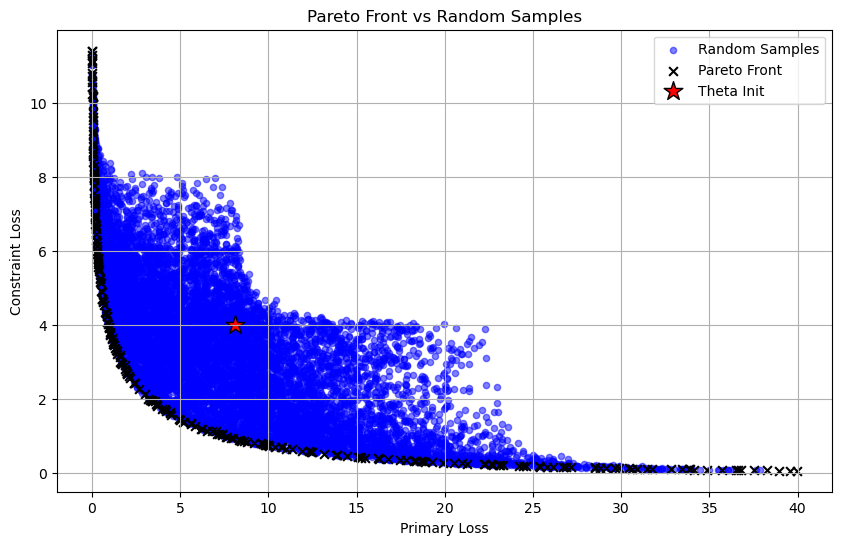

In [395]:
plt.figure(figsize=(10, 6)) 
plt.scatter(primary_losses, constraint_losses, color='blue', alpha=0.5, label='Random Samples', s=20)
plt.scatter(pareto_primary, pareto_constraint, color='black', label='Pareto Front', s=40, marker='x')
# plt.scatter(pareto_primary_exact, pareto_constraint_exact, color='black', label='Pareto Front', s=40)
plt.scatter(primary_loss_convex(theta_init),
            constraint_function_convex(theta_init),
            color='red', s=200, marker='*', label='Theta Init',
            edgecolors='black', linewidths=1)


plt.xlabel('Primary Loss')
plt.ylabel('Constraint Loss')
plt.title('Pareto Front vs Random Samples')
plt.legend()
plt.grid(True)
plt.show()

Generating 10000 random samples: 100%|██████████| 10000/10000 [00:00<00:00, 25476.23it/s]
/tmp/ipykernel_4671/3406694536.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta_init, requires_grad=True)


Running Convex Case...


100%|██████████| 1000/1000 [00:00<00:00, 3128.34it/s]


Running Convex Case...


100%|██████████| 5000/5000 [00:01<00:00, 3075.40it/s]


Running Convex Case...


100%|██████████| 10000/10000 [00:03<00:00, 3017.99it/s]


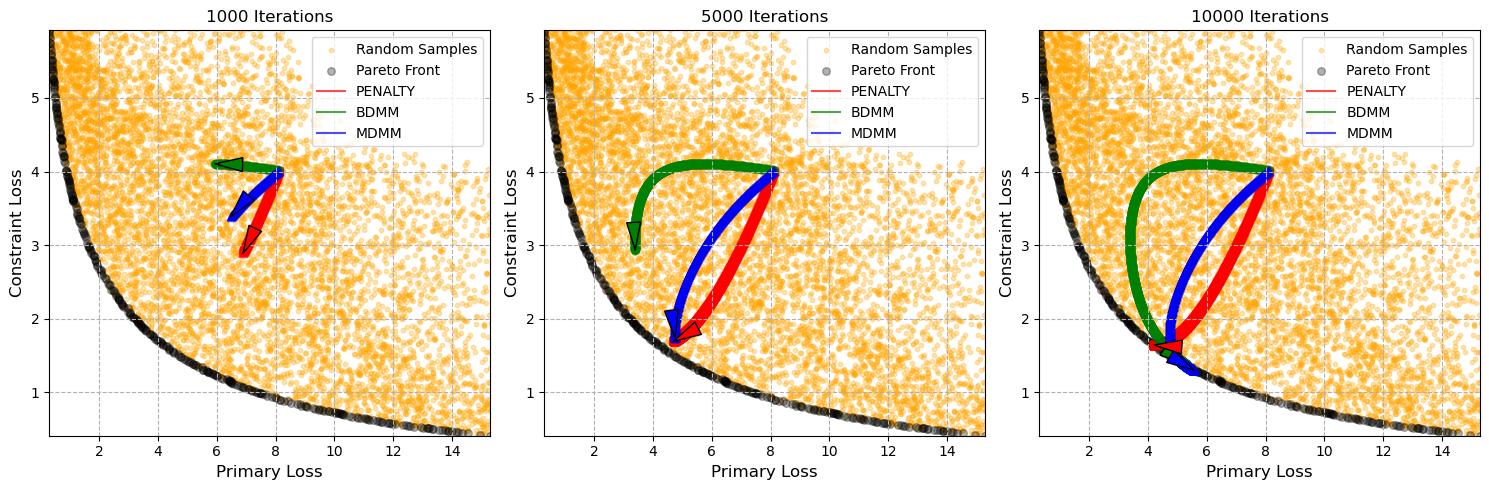

In [400]:
lr = 0.0002
iterations_list = [1000, 5000, 10000] 
lambda_init = 0.0
lambda_penalty = 1.0
damping = 1.0

methods = ['penalty', 'bdmm', 'mdmm']

case = {
        'name': 'Convex',
        'primary_loss_func': primary_loss_convex,
        'constraint_func': constraint_function_convex,
        'theta_range':theta_range,
        'theta_init': theta_init,
        }

pareto_primary, pareto_constraint = compute_pareto_front(
                                                        case['primary_loss_func'],
                                                        case['constraint_func'],
                                                        theta_size=theta_size,
                                                        theta_range=[-2,2],
                                                        num_samples=10000  
                                                        )
random_primary, random_constraint, _ = generate_random_samples(
                                        case['primary_loss_func'],
                                        case['constraint_func'],
                                        theta_size=theta_size,  
                                        theta_range=theta_range,
                                        num_samples=10000
)

plt.figure(figsize=(15, 5))

for i, iterations in enumerate(iterations_list):
    plt.subplot(1, len(iterations_list), i + 1) 

    plt.scatter(random_primary, random_constraint, color='orange', alpha=0.3, label='Random Samples', s=10, zorder=0)
    plt.scatter(pareto_primary, pareto_constraint, color='black', alpha=0.3, label='Pareto Front', s=30, zorder=0)
    
    _, _, _, _, thetas = run_experient(lr=lr, iterations=iterations, lambda_init=lambda_init,
                  lambda_penalty=lambda_penalty, damping=damping, case=case, methods = methods)
    plt.title(f'{iterations} Iterations') 

    dx = (pareto_primary.max() - pareto_primary.min())*0.01
    dy = (pareto_constraint.max() - pareto_constraint.min())*0.01
    plt.xlim([pareto_primary.min(), pareto_primary.max()])
    plt.ylim([pareto_constraint.min(), pareto_constraint.max()])
    
    
plt.tight_layout()
plt.savefig("Convex_PF_PBM.png")
plt.show()

In [401]:
def primary_loss_concave(theta):
    return -theta[0]**2 + 1 - theta[0] + theta[1]**2

def constraint_loss_concave(theta):
    return -theta[0]**2 + 1 + theta[0] + theta[1]**2


def primary_loss_concave(theta):
    return theta[0]**4 - theta[0]**3 - 2*theta[0]**2 + 2*theta[0] + 1 + torch.sum(theta[1:] ** 2)

def constraint_loss_concave(theta):
    return theta[0]**4 - theta[0]**3 - 2*theta[0]**2  + 1 + torch.sum(theta[1:] ** 2)


In [414]:
target_primary_loss = 2
target_constraint_loss = 1.5

theta_size = 2
theta_range = (-5, 5)

best_theta = None
best_primary_loss = float('inf')
best_constraint_loss = float('inf')
tolerance = 0.1
num_iterations = 10000
for i in tqdm(range(num_iterations)):
    theta_init = torch.rand(theta_size) * (theta_range[1] - theta_range[0]) + theta_range[0]
    primary_loss_value = primary_loss_concave(theta_init)
    constraint_loss_value = constraint_loss_concave(theta_init)
    if abs(primary_loss_value - target_primary_loss) < tolerance and abs(constraint_loss_value - target_constraint_loss) < tolerance:
        print(f"Found solution in iteration {i}:")
        print(f"theta: {theta_init}")
        print(f"primary_loss: {primary_loss_value}, constraint_loss: {constraint_loss_value}")
        break
    if (abs(primary_loss_value - target_primary_loss) + abs(constraint_loss_value - target_constraint_loss)) < \
       (abs(best_primary_loss - target_primary_loss) + abs(best_constraint_loss - target_constraint_loss)):
        best_theta = theta_init
        best_primary_loss = primary_loss_value
        best_constraint_loss = constraint_loss_value

 25%|██▍       | 2465/10000 [00:00<00:01, 5063.79it/s]

Found solution in iteration 2465:
theta: tensor([0.2849, 0.7612])
primary_loss: 1.9703172445297241, constraint_loss: 1.4006093740463257


In [455]:
theta_size = 2
theta_range = (-1, 1)
theta_init = torch.rand(theta_size) * (theta_range[1] - theta_range[0]) + theta_range[0]
theta_init = best_theta
print(theta_init)
(primary_loss_concave(theta_init), constraint_loss_concave(theta_init))

tensor([ 0.1865, -0.8617])


(tensor(2.0406), tensor(1.6676))

In [456]:
theta_range = (-1, 1) 
num_samples=10000

primary_losses, constraint_losses, _ = generate_random_samples(primary_loss_concave,
                                                               constraint_loss_concave,
                                                               theta_size=theta_size, theta_range=theta_range, 
                                                               num_samples=num_samples)

pareto_primary, pareto_constraint = compute_pareto_front(primary_loss_concave,
                                                         constraint_loss_concave,
                                                         theta_size=theta_size, 
                                                         theta_range=theta_range,
                                                         num_samples=num_samples)

Computing Pareto Front: 100%|██████████| 10000/10000 [00:00<00:00, 21212.16it/s]


In [457]:
pareto_primary, pareto_constraint = compute_pareto_front_positive(primary_loss_concave,
                                                         constraint_loss_concave,
                                                         theta_size=theta_size, 
                                                         theta_range=theta_range,
                                                         num_samples=10**4, num_rays = 180)

Casting rays and collecting collisions: 100%|██████████| 180/180 [00:00<00:00, 3504.22it/s]


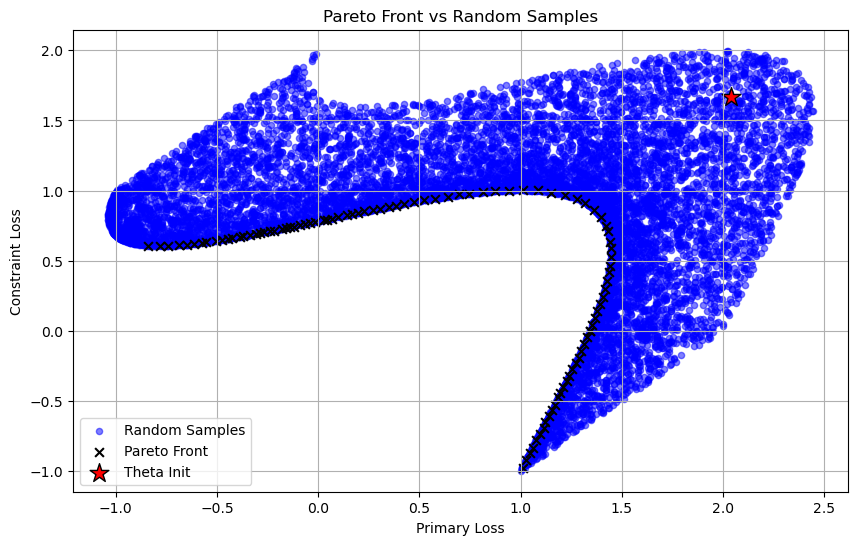

In [458]:
plt.figure(figsize=(10, 6)) 
plt.scatter(primary_losses, constraint_losses, color='blue', alpha=0.5, label='Random Samples', s=20)
plt.scatter(pareto_primary, pareto_constraint, color='black', label='Pareto Front', s=40, marker='x')
plt.scatter(primary_loss_concave(theta_init),
            constraint_loss_concave(theta_init),
            color='red', s=200, marker='*', label='Theta Init',
            edgecolors='black', linewidths=1)


plt.xlabel('Primary Loss')
plt.ylabel('Constraint Loss')
plt.title('Pareto Front vs Random Samples')
plt.legend()
plt.grid(True)
plt.show()

Generating 10000 random samples: 100%|██████████| 10000/10000 [00:01<00:00, 8921.08it/s]
/tmp/ipykernel_4671/3406694536.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta_init, requires_grad=True)


Running Convex Case...


100%|██████████| 1000/1000 [00:00<00:00, 1445.26it/s]


Running Convex Case...


100%|██████████| 10000/10000 [00:07<00:00, 1378.08it/s]


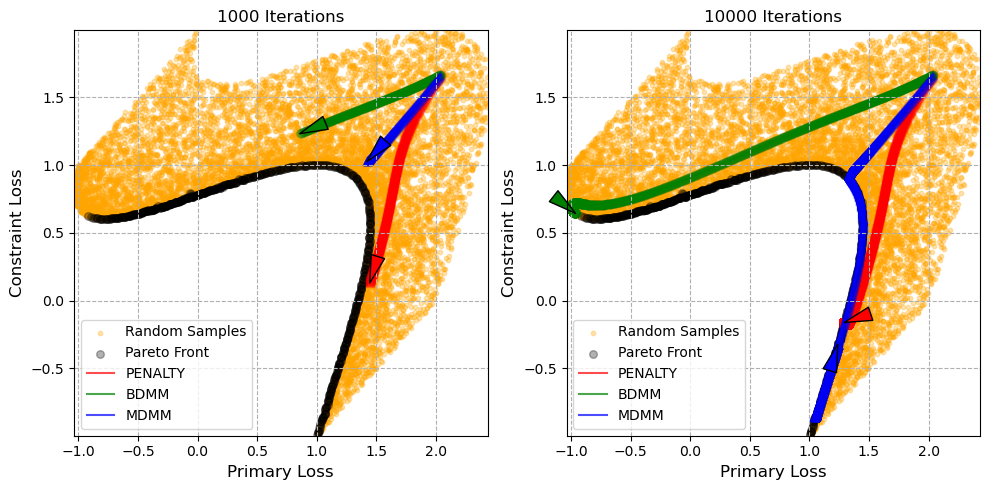

In [459]:
lr = 2e-4
iterations_list = [1000, 10000] 
lambda_init = 0.0
lambda_penalty = 1.0
damping = 1.0
theta_range = [-1, 1]

methods = ['penalty', 'bdmm', 'mdmm']

case = {
        'name': 'Convex',
        'primary_loss_func': primary_loss_concave,
        'constraint_func': constraint_loss_concave,
        'theta_range':theta_range,
        'theta_init': theta_init,
        }

pareto_primary, pareto_constraint = compute_pareto_front_positive(
                                                        case['primary_loss_func'],
                                                        case['constraint_func'],
                                                        theta_size=theta_size,
                                                        theta_range=theta_range,
                                                        num_samples=10000  
                                                        )
random_primary, random_constraint, _ = generate_random_samples(
                                        case['primary_loss_func'],
                                        case['constraint_func'],
                                        theta_size=theta_size,  
                                        theta_range=theta_range,
                                        num_samples=10000
)

plt.figure(figsize=(10, 5))

for i, iterations in enumerate(iterations_list):
    plt.subplot(1, len(iterations_list), i + 1) 

    plt.scatter(random_primary, random_constraint, color='orange', alpha=0.3, label='Random Samples', s=10, zorder=0)
    plt.scatter(pareto_primary, pareto_constraint, color='black', alpha=0.3, label='Pareto Front', s=30, zorder=0)
    
    _, _, _, _, thetas = run_experient(lr=lr, iterations=iterations, lambda_init=lambda_init,
                  lambda_penalty=lambda_penalty, damping=damping, case=case, methods = methods)
    plt.title(f'{iterations} Iterations') 

    dx = (random_primary.max() - random_primary.min())*0.01
    dy = (random_constraint.max() - random_constraint.min())*0.01
    plt.xlim([random_primary.min(), random_primary.max()])
    plt.ylim([random_constraint.min(), random_constraint.max()])
    
    
plt.tight_layout()
plt.savefig("Concave_PF_PBM.png")
plt.show()

/tmp/ipykernel_4671/3406694536.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta_init, requires_grad=True)


Running Convex Case...


100%|██████████| 100000/100000 [01:09<00:00, 1446.56it/s]


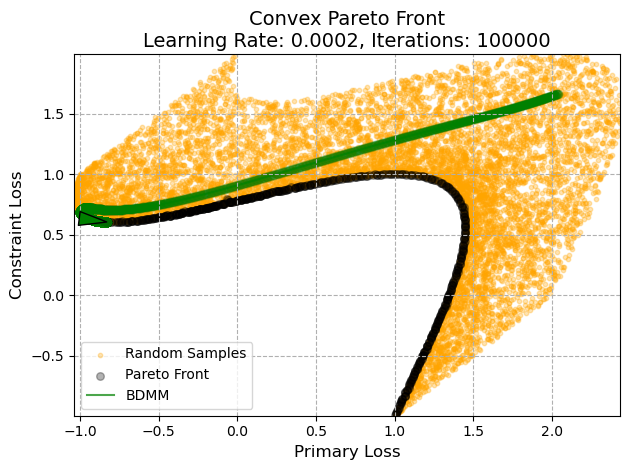

In [464]:
plt.scatter(random_primary, random_constraint, color='orange', alpha=0.3, label='Random Samples', s=10, zorder=0)
plt.scatter(pareto_primary, pareto_constraint, color='black', alpha=0.3, label='Pareto Front', s=30, zorder=0)

_, _, losses, lmbdas, thetas = run_experient(lr=2e-4, iterations=100000, lambda_init=lambda_init,
                  lambda_penalty=lambda_penalty, damping=0.85, case=case, methods = ['bdmm'])

plt.xlim([random_primary.min(), random_primary.max()])
plt.ylim([random_constraint.min(), random_constraint.max()])
plt.show()

/tmp/ipykernel_4671/3406694536.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta_init, requires_grad=True)


Running Convex Case...


100%|██████████| 10000/10000 [00:07<00:00, 1411.39it/s]


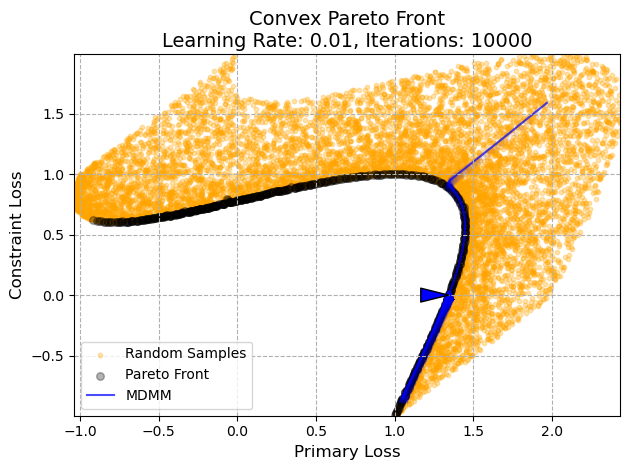

In [475]:
plt.scatter(random_primary, random_constraint, color='orange', alpha=0.3, label='Random Samples', s=10, zorder=0)
plt.scatter(pareto_primary, pareto_constraint, color='black', alpha=0.3, label='Pareto Front', s=30, zorder=0)

_, _, losses, lmbdas, thetas = run_experient(lr=1e-2, iterations=10000, lambda_init=lambda_init,
                  lambda_penalty=lambda_penalty, damping=1, case=case, methods = ['mdmm'])

plt.xlim([random_primary.min(), random_primary.max()])
plt.ylim([random_constraint.min(), random_constraint.max()])
plt.show()

In [460]:
# plt.scatter(random_primary, random_constraint, color='orange', alpha=0.3, label='Random Samples', s=10, zorder=0)
# plt.scatter(pareto_primary, pareto_constraint, color='black', alpha=0.3, label='Pareto Front', s=30, zorder=0)

# _, _, losses, lmbdas, thetas = run_experient(lr=4e-4, iterations=10000, lambda_init=lambda_init,
#                   lambda_penalty=lambda_penalty, damping=0.85, case=case, methods = ['mdmm'])

# plt.xlim([random_primary.min(), random_primary.max()])
# plt.ylim([random_constraint.min(), random_constraint.max()])
# plt.show()

In [476]:
def run_experient_penalty(lr = 0.001,
                        iterations =100,
                        lambda_init = 0.0,
                        lambda_penalty = 10.0,
                        color = 'red',
                        marker = 'o',
                        case = {
                                'name': 'Convex',
                                'primary_loss_func': primary_loss_convex,
                                'constraint_func': constraint_function_convex,
                                'theta_range': [-4, 4],
                                'theta_init': -3.0,
                                }
                        ):
    
   
    print(f"Running {case['name']} Case...") 
    losses, constraints, lmbdas, thetas = optimize_method(
                                            primary_loss_func=case['primary_loss_func'],
                                            constraint_func=case['constraint_func'],
                                            theta_init=case['theta_init'],
                                            method='penalty',
                                            lambda_init=lambda_init,
                                            lambda_penalty=lambda_penalty,
                                            damping=1.0,
                                            lr=lr,
                                            iterations=iterations
                                        )
                                            
    plt.scatter(losses, constraints, c=color, marker=marker, alpha=0.05, zorder=0)
    plt.plot(losses, constraints, label=rf'$\lambda$ = {lambda_penalty}',
             c=color, marker=None, alpha=0.7, zorder=0)

    filtered_losses = remove_consecutive_duplicates(losses)
    filtered_constraints = remove_consecutive_duplicates(constraints)
        
    if len(filtered_losses) >= 2 and len(filtered_constraints) >= 2:
        plt.annotate('',
                     xy=(filtered_losses[-1], filtered_constraints[-1]),
                     xytext=(filtered_losses[-2], filtered_constraints[-2]),
                     arrowprops=dict(facecolor=color, shrink=0.05,
                                     headwidth=10, headlength=20, width=2),
                     zorder=3)

    return plt, losses, constraints, lmbdas, thetas

/tmp/ipykernel_4671/3406694536.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta_init, requires_grad=True)


Running Convex Case...


100%|██████████| 10000/10000 [00:06<00:00, 1489.89it/s]


Running Convex Case...


100%|██████████| 10000/10000 [00:06<00:00, 1499.54it/s]


Running Convex Case...


100%|██████████| 10000/10000 [00:06<00:00, 1457.68it/s]


Running Convex Case...


100%|██████████| 10000/10000 [00:06<00:00, 1503.51it/s]


Running Convex Case...


100%|██████████| 10000/10000 [00:06<00:00, 1485.81it/s]


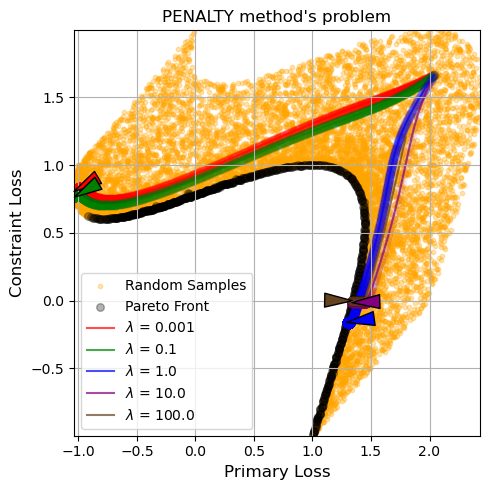

In [490]:
lambda_penalty_values = [0.001, 0.1, 1.0, 10.0, 100.0]
colors = ['red', 'green', 'blue', 'purple', '#654321']
markers = ['s', 'o', '^', 'D']
case = {
        'name': 'Convex',
        'primary_loss_func': primary_loss_concave,
        'constraint_func': constraint_loss_concave,
        'theta_range':theta_range,
        'theta_init': theta_init,
        }


plt.figure(figsize=(5, 5))

plt.scatter(random_primary, random_constraint, color='orange', alpha=0.3, label='Random Samples', s=10, zorder=0)
plt.scatter(pareto_primary, pareto_constraint, color='black', alpha=0.3, label='Pareto Front', s=30, zorder=0)

for i, lambda_penalty in enumerate(lambda_penalty_values):
    _, _, losses, lmbdas, thetas = run_experient_penalty(
        lr=4e-4, 
        iterations=10000, 
        lambda_init=lambda_init,
        lambda_penalty=lambda_penalty, 
        case=case, 
        color = colors[i]
    )

plt.xlim([random_primary.min(), random_primary.max()])
plt.ylim([random_constraint.min(), random_constraint.max()])
plt.xlabel('Primary Loss', fontsize=12)
plt.ylabel('Constraint Loss', fontsize=12)
plt.title("PENALTY method's problem")

plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.savefig("Concave_Penalty.png")
plt.show()


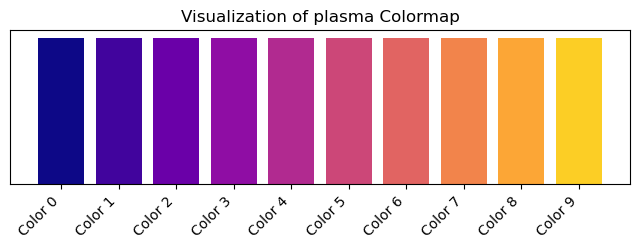

In [484]:

cmap = plt.get_cmap('plasma') 
n_colors = 10

plt.figure(figsize=(8, 2))
for i in range(n_colors):
    plt.bar(i, 1, color=cmap(i / n_colors))

plt.xticks(np.arange(n_colors), labels=[f'Color {i}' for i in range(n_colors)], rotation=45, ha='right')
plt.yticks([]) 
plt.title(f"Visualization of {cmap.name} Colormap")
plt.show()


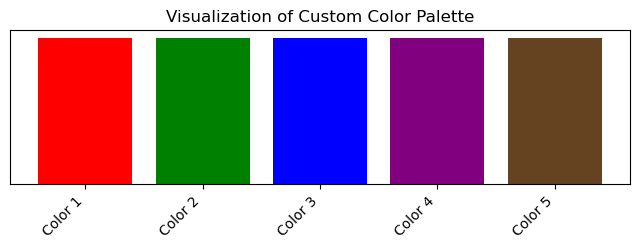

In [489]:
colors = ['red', 'green', 'blue', 'purple', '#654321']

plt.figure(figsize=(8, 2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color)

plt.xticks(range(len(colors)), labels=[f'Color {i+1}' for i in range(len(colors))], rotation=45, ha='right')
plt.yticks([])  
plt.title("Visualization of Custom Color Palette")
plt.show()
